In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from nltk.tokenize import word_tokenize

#For Stemming text
from nltk.stem import PorterStemmer

import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer

#To split data into train and test
from sklearn.model_selection import train_test_split

#For fitting model
from sklearn.linear_model import LogisticRegression

#For evaluation of model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Data collection

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michiard/sentiment-analysis-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.25M/1.25M [00:00<00:00, 52.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/michiard/sentiment-analysis-dataset/versions/1


In [3]:
print(os.listdir(path))

df = pd.read_csv(path+'/train.csv')

print(df.head())

['test.csv', 'sample_submission.csv', 'train.csv']
       textID                                               text  \
0  28ac06f416                        good luck with your auction   
1  92098cf9a7  Hmm..You can`t judge a book by looking at its ...   
2  7858ff28f2   Hello, yourself. Enjoy London. Watch out for ...   
3  b0c9c67f32         We can`t even call you from belgium  sucks   
4  7b36e9e7a5                                 not so good mood..   

                                       selected_text sentiment  
0                        good luck with your auction  positive  
1  Hmm..You can`t judge a book by looking at its ...   neutral  
2                                    They`re mental.  negative  
3                                            m  suck  negative  
4                                 not so good mood..  negative  


In [4]:
print(df.info())
print("Columns: " + df.columns)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24732 entries, 0 to 24731
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         24732 non-null  object
 1   text           24732 non-null  object
 2   selected_text  24732 non-null  object
 3   sentiment      24732 non-null  object
dtypes: object(4)
memory usage: 773.0+ KB
None
Index(['Columns: textID', 'Columns: text', 'Columns: selected_text',
       'Columns: sentiment'],
      dtype='object')
(24732, 4)


In [5]:
df.describe(include='all')

,textID,text,selected_text,sentiment
count,24732,24732,24732,24732
unique,24732,24732,20298,3
top,dfa774bd3d,Content content content .... gah! Story of my...,love,neutral
freq,1,1,174,10018


In [6]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,10018
positive,7711
negative,7003


<ipython-input-7-6f9b97815d82>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='bright')


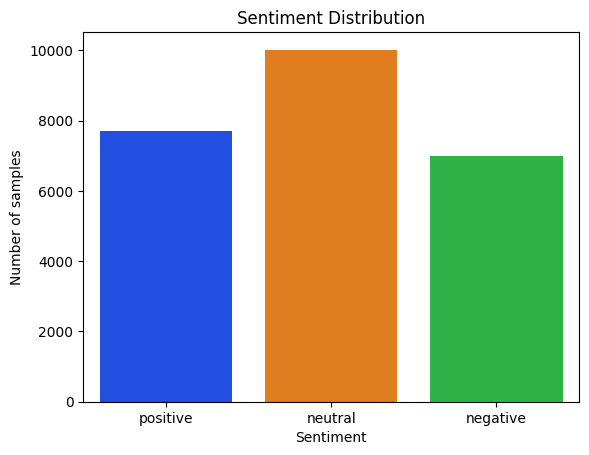

In [7]:
# Plot
sns.countplot(x='sentiment', data=df, palette='bright')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of samples')
plt.show()

# Preprocessing

## Text cleansing

In [8]:
'''
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


# Carica modello spaCy
nlp = spacy.load("en_core_web_sm")

# Stopwords personalizzate (manteniamo le negazioni)
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # Rimuove punteggiatura
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenizzazione
    tokens = word_tokenize(text.lower())

    # Lemmatizzazione con spaCy (sul testo completamente lowercase)
    doc = nlp(" ".join(tokens).lower())
    lemmatized_tokens = [token.lemma_.lower() for token in doc]


    # Rimozione stopwords
    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]

    return final_tokens

df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))
'''

'\nimport nltk\nimport spacy\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nimport string\n\n\n# Carica modello spaCy\nnlp = spacy.load("en_core_web_sm")\n\n# Stopwords personalizzate (manteniamo le negazioni)\nstop_words = set(stopwords.words(\'english\'))\nnegations = {\'no\', \'not\', \'nor\'}\nstop_words = stop_words.difference(negations)\n\ndef preprocess_text(text):\n    # Rimuove punteggiatura\n    text = text.translate(str.maketrans(\'\', \'\', string.punctuation))\n    \n    # Tokenizzazione\n    tokens = word_tokenize(text.lower())\n    \n    # Lemmatizzazione con spaCy (sul testo completamente lowercase)\n    doc = nlp(" ".join(tokens).lower())\n    lemmatized_tokens = [token.lemma_.lower() for token in doc]\n\n    \n    # Rimozione stopwords\n    final_tokens = [token for token in lemmatized_tokens if token not in stop_words and token.strip()]\n    \n    return final_tokens\n\ndf[\'removed_stop_words\'] = df[\'text\'].apply(lambda x: preprocess

In [9]:
!pip install spacy nltk num2words
!python -m nltk.downloader punkt stopwords
!python -m spacy download en_core_web_sm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 5.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ed1237d60fa68df973195058f92d009de52b94f0eee28b3128b3531d86b841ab
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm'

In [20]:
import re
import string
import unicodedata
import nltk
import spacy
from nltk.corpus import stopwords
from num2words import num2words

# Downloads if needed
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Custom stopwords keeping negations
stop_words = set(stopwords.words('english'))
negations = {'no', 'not', 'nor'}
stop_words = stop_words.difference(negations)

def preprocess_text(text):
    # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 2. Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # 3. Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')

    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Convert numbers to words
    def replace_numbers(match):
        return num2words(match.group())
    text = re.sub(r'\b\d+\b', replace_numbers, text)

    # 6. Lowercase
    text = text.lower()

    # 7. Lemmatize and tokenize with spaCy
    doc = nlp(text)

    # 8. Remove stopwords and non-alpha tokens
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.lemma_.lower() not in stop_words and token.lemma_.isalpha()
    ]

    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
df['removed_stop_words'] = df['text'].apply(lambda x: preprocess_text(x))

In [22]:
df.sample(10)

,textID,text,selected_text,sentiment,removed_stop_words,processed_text
5504,7f1bc73a3b,Ugh. Going to skool,Ugh. Going to skool,neutral,"[ugh, go, skool]",ugh go skool
7421,d6daf5cd2b,my boss. She`s moving to NYC,my boss. She`s moving to NYC,neutral,"[boss, move, nyc]",boss move nyc
10514,51f3420c03,i have been getting **** ones as i mention...,d - all these girls seem to be at a los,negative,"[get, one, mention, girl, seem, loss]",get one mention girl seem loss
4518,4e914d79e9,finally got home and get to sleep! had a great...,had a great time,positive,"[finally, get, home, get, sleep, great, time, ...",finally get home get sleep great time friend
4071,a9e5b6a9f8,Pissed at you http://myloc.me/21CU,Pissed at you,negative,[piss],piss
21250,7b7f672bff,tonight in party w/ my girls (minus vita),tonight in party w/ my girls (minus vita),positive,"[tonight, party, w, girl, minus, vita]",tonight party w girl minus vita
4540,0df4545864,Happy Mother`s Day to all of the mothers and m...,Happy Mother`s Day,positive,"[happy, mother, day, mother, motherstobe, mom,...",happy mother day mother motherstobe mom get sp...
18945,54cb84a979,Yeah :p,Yeah :p,neutral,"[yeah, p]",yeah p
10119,3ceefccbc8,"most definately! They are having a hard time,...","They are having a hard time,",negative,"[definately, hard, time, cuz, young, never, se...",definately hard time cuz young never see wrkd ...
21209,8dcc4221eb,"**** another day at the office, the sun is bur...","**** another day at the office, the sun is bur...",neutral,"[another, day, office, sun, burst, skyand, wom...",another day office sun burst skyand woman eh w...


In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the unique sentiment classes you want to generate clouds for
sentiments = ['neutral', 'positive', 'negative']

# Loop through each class
for sentiment in sentiments:
    # Filter the DataFrame by sentiment class
    subset = df[df['sentiment'] == sentiment]

    # Flatten the token lists into a single string
    all_words = ' '.join([' '.join(tokens) for tokens in subset['removed_stop_words']])

    # Generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    # Display the word cloud (optional)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.capitalize()} WordCloud', fontsize=16)

    # Save the figure locally
    filename = f"{sentiment}_wordcloud.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()  # Close the plot to avoid displaying all of them in notebook

    print(f"Saved: {filename}")


Saved: neutral_wordcloud.png
Saved: positive_wordcloud.png
Saved: negative_wordcloud.png


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score

In [26]:
# Parametri
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

In [27]:
# ============================
# 3. Tokenizzazione e Padding
# ============================

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df["processed_text"])
sequences = tokenizer.texts_to_sequences(df["processed_text"])
X_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
# ============================
# 4. Encoding etichette
# ============================

le = LabelEncoder()
y_encoded = le.fit_transform(df["sentiment"])

In [29]:
# ============================
# 5. Train / Val / Test Split
# ============================

X_train_seq, X_temp_seq, y_train_enc, y_temp_enc = train_test_split(
    X_seq, y_encoded, test_size=0.30, stratify=y_encoded, random_state=42
)
X_val_seq, X_test_seq, y_val_enc, y_test_enc = train_test_split(
    X_temp_seq, y_temp_enc, test_size=0.50, stratify=y_temp_enc, random_state=42
)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# 📁 Percorso al file GloVe (modifica se sta in una sottocartella)
glove_path = "/content/drive/MyDrive/glove.6B.100d.txt"

# 📥 Caricamento GloVe
embedding_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

print("Caricate parole:", len(embedding_index))

Caricate parole: 400000


In [33]:
# ============================
# 7. Creazione embedding matrix
# ============================

word_index = tokenizer.word_index
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [34]:
# ============================
# 8. Definizione modello LSTM
# ============================

model = Sequential([
    Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')  # 3 classi: positive, neutral, negative
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
# ============================
# 9. Addestramento
# ============================

history = model.fit(X_train_seq, y_train_enc,
                    validation_data=(X_val_seq, y_val_enc),
                    epochs=5, batch_size=64)

Epoch 1/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 80s 273ms/step - accuracy: 0.5385 - loss: 0.9640 - val_accuracy: 0.6456 - val_loss: 0.8056
Epoch 2/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 80s 265ms/step - accuracy: 0.6512 - loss: 0.7976 - val_accuracy: 0.6854 - val_loss: 0.7455
Epoch 3/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 72s 266ms/step - accuracy: 0.6676 - loss: 0.7595 - val_accuracy: 0.6933 - val_loss: 0.7222
Epoch 4/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 85s 276ms/step - accuracy: 0.6950 - loss: 0.7190 - val_accuracy: 0.6976 - val_loss: 0.7078
Epoch 5/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 79s 267ms/step - accuracy: 0.6984 - loss: 0.7044 - val_accuracy: 0.7073 - val_loss: 0.6882


In [36]:
# ============================
# 10. Valutazione
# ============================

y_pred = model.predict(X_test_seq).argmax(axis=1)
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
print("Macro F1:", f1_score(y_test_enc, y_pred, average='macro'))

116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step
=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.74      0.64      0.69      1051
     neutral       0.67      0.72      0.69      1503
    positive       0.75      0.77      0.76      1156

    accuracy                           0.71      3710
   macro avg       0.72      0.71      0.71      3710
weighted avg       0.71      0.71      0.71      3710

Macro F1: 0.7133920243270886


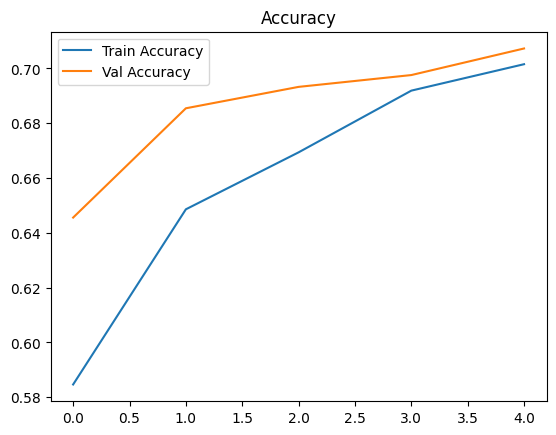

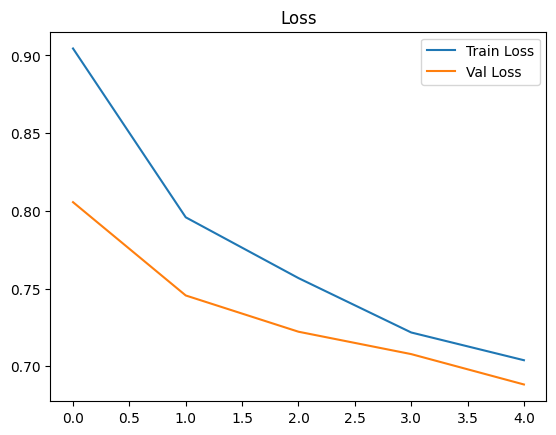

In [37]:
# ============================
# 11. Grafici
# ============================

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [38]:
!pip install keras-tuner --quiet  # solo la prima volta

from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))

    model.add(LSTM(
        units=hp.Int('units', min_value=64, max_value=256, step=64),
        dropout=hp.Choice('dropout', values=[0.2, 0.3, 0.4]),
        recurrent_dropout=hp.Choice('recurrent_dropout', values=[0.2, 0.3])
    ))

    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='glove_lstm_tuning'
)

tuner.search(X_train_seq, y_train_enc,
             validation_data=(X_val_seq, y_val_enc),
             epochs=5, batch_size=64)

# Miglior modello trovato
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 16m 09s]
val_accuracy: 0.7053908109664917

Best val_accuracy So Far: 0.7053908109664917
Total elapsed time: 01h 25m 57s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [39]:
# ============================
# 10. Valutazione del modello
# ============================

# Predizione sul test set
y_pred = best_model.predict(X_test_seq).argmax(axis=1)

# Classification report e F1
from sklearn.metrics import classification_report, f1_score

print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
print("Macro F1:", f1_score(y_test_enc, y_pred, average='macro'))

116/116 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step
=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.71      0.68      0.69      1051
     neutral       0.67      0.70      0.69      1503
    positive       0.76      0.76      0.76      1156

    accuracy                           0.71      3710
   macro avg       0.72      0.71      0.71      3710
weighted avg       0.71      0.71      0.71      3710

Macro F1: 0.7132253093759909


Epoch 1/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 188s 677ms/step - accuracy: 0.6925 - loss: 0.7158 - val_accuracy: 0.7075 - val_loss: 0.6859
Epoch 2/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 197s 659ms/step - accuracy: 0.7000 - loss: 0.7135 - val_accuracy: 0.7146 - val_loss: 0.6845
Epoch 3/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 213s 696ms/step - accuracy: 0.7081 - loss: 0.6890 - val_accuracy: 0.7156 - val_loss: 0.6776
Epoch 4/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 198s 685ms/step - accuracy: 0.7171 - loss: 0.6738 - val_accuracy: 0.7240 - val_loss: 0.6693
Epoch 5/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 194s 658ms/step - accuracy: 0.7203 - loss: 0.6642 - val_accuracy: 0.7229 - val_loss: 0.6739


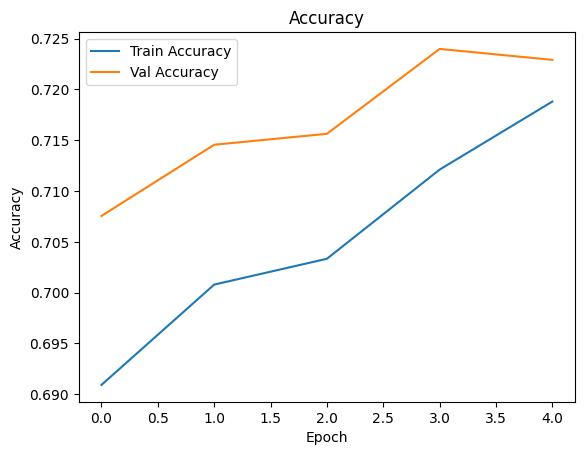

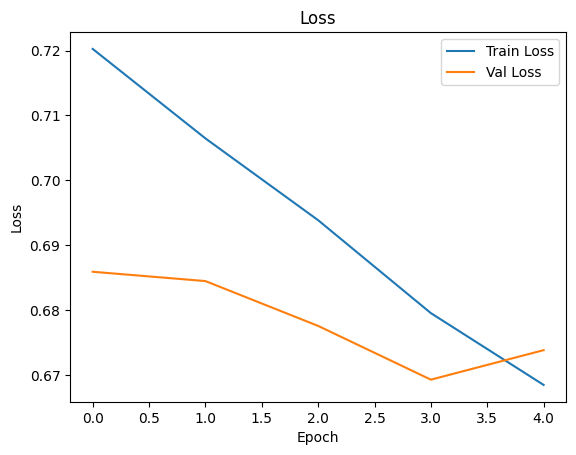

In [40]:
# ============================
# Grafici (accuratezza e perdita NON disponibili con tuner, quindi riaddestriamo per plot)
# ============================

# Riaddestramento (opzionale) per ottenere i grafici
history = best_model.fit(X_train_seq, y_train_enc,
                         validation_data=(X_val_seq, y_val_enc),
                         epochs=5, batch_size=64)

import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

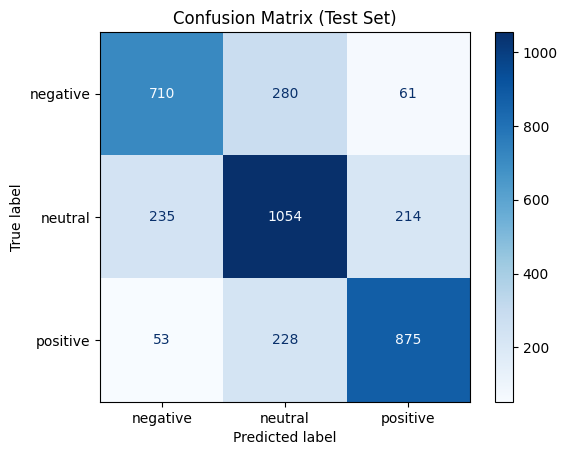

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)

# Display con etichette leggibili
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')  # 'd' = integer
plt.title("Confusion Matrix (Test Set)")
plt.show()